In [ ]:
from zipfile import ZipFile

import pandas as pd
import tarfile

# BERTopic installation

In [ ]:
%%capture
!pip install bertopic

In [ ]:
%%capture
!pip install distributed==2021.9.0

# Data

Load the data that we want to use for topic modeling.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# path to file location on google drive
archive = "/content/drive/MyDrive/colab_data/newsapi/newsapi.tar.gz"

In [ ]:
# read from zipfile
"""
archive_df = pd.json_normalize(
    pd.concat(
        [pd.read_json(ZipFile(archive).open(i), encoding="utf-8") for i in ZipFile(archive).namelist()],
        ignore_index=True
    )["articles"]
)
"""

# read from tarfile
tar = tarfile.open(archive, mode='r:gz')
tarnames = tar.getmembers()
archive_df = pd.json_normalize(
    pd.concat(
        [pd.read_json(tar.extractfile(i)) for i in tarnames if i.isfile()],
        ignore_index=True
    )["articles"]
)
tar.close()

# convert publishedAt to something that is easier to read and work with
dates = pd.to_datetime(archive_df["publishedAt"]).dt.date
year = dates.apply(lambda x: int(str(x).split("-")[0]))
archive_df["year"] = year

archive_df.head(1)

author  ...  year
0  Daily News  ...  2020

[1 rows x 10 columns]

Next, we remove duplicate or empty entries.

In [ ]:
# drop rows that have empty 'content' column
archive_df = archive_df[archive_df["content"].notna()]

In [ ]:
# drop duplicates
archive_df.drop_duplicates(subset="content", inplace=True)

In [ ]:
# total number of articles
len(archive_df)

1128246

In [ ]:
# list of sources
archive_df['source.name'].unique()

array(['AllAfrica - Top Africa News', 'Phys.Org', 'Business Insider',
       'Independent', 'Science Daily', 'CNA', 'The Verge',
       'The Washington Post', 'POLITICO.eu', 'Al Jazeera English', 'CNN',
       'TechRadar', 'Axios', 'TechCrunch', 'Wired', 'BBC News',
       'The Wall Street Journal', 'Vice News', 'Hindustan Times',
       'The Economist', 'Science Magazine', 'Nature.com', 'Jakarta Post'],
      dtype=object)

### Data subset selection

In [ ]:
archive_df = archive_df[((archive_df["source.name"] == "The Economist") |
                        (archive_df["source.name"] == "Phys.Org") |
                        (archive_df["source.name"] == "Business Insider") |
                        (archive_df["source.name"] == "Science Daily") |
                        (archive_df["source.name"] == "The Verge") |
                        (archive_df["source.name"] == "TechRadar") |
                        (archive_df["source.name"] == "TechCrunch") |
                        (archive_df["source.name"] == "Wired") |
                        (archive_df["source.name"] == "The Wall Street Journal") |
                        (archive_df["source.name"] == "Science Magazine") |
                        (archive_df["source.name"] == "Nature.com")) &
                        (archive_df["year"] == 2021)]

In [ ]:
# archive_df = archive_df[(archive_df["year"] == 2020) & (archive_df["source.name"] == "The Economist")]
# archive_df = archive_df[archive_df["year"] == 2020]

In [ ]:
# reset the index, otherwise everything gets messed up
archive_df.reset_index(drop=True, inplace=True)

In [ ]:
# final number of texts
len(archive_df)

152525

Check the amount of texts that we have:

In [ ]:
archive_df["source.name"].value_counts()

Business Insider           43664
TechRadar                  21384
Phys.Org                   21321
TechCrunch                 17264
Science Daily              11562
Nature.com                 10660
The Verge                   9754
The Wall Street Journal     6161
The Economist               4040
Science Magazine            3696
Wired                       3019
Name: source.name, dtype: int64

# Training

In [ ]:
from bertopic import BERTopic

In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
# topics, prob = topic_model.fit_transform(archive_df["content"])

In [ ]:
topics, prob = topic_model.fit_transform(archive_df["content"])

Batches:   0%|          | 0/4767 [00:00<?, ?it/s]

2021-12-07 13:20:40,436 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2021-12-07 13:22:54,456 - BERTopic - Reduced dimensionality with UMAP


BrokenProcessPool: ignored

# Extracting topics

In [ ]:
# most frequent topics
freq = topic_model.get_topic_info(); freq.head(5)

Topic  Count                                  Name
0     -1   7494  -1_capital_startup_platform_facebook
1      0    314       0_banking_bank_payments_payment
2      1    239   1_students_edtech_education_courses
3      2    214        2_virus_disease_deaths_covid19
4      3    196       3_robotics_robots_robot_robotic

In [ ]:
# most important tokens for a topic
topic_model.get_topic(0)

[('banking', 0.009935695234644519),
 ('bank', 0.008258715089797464),
 ('payments', 0.006510460385202139),
 ('payment', 0.005971585554610714),
 ('debit', 0.00545976227817509),
 ('banks', 0.004752516751339799),
 ('transactions', 0.004189848529589871),
 ('accounts', 0.0037662652293446114),
 ('stripe', 0.0035340726081493543),
 ('fees', 0.0034890167317334925)]

# Visualization

Different visualization options included in BERTopic.

## Visualizing topics

In [ ]:
topic_model.visualize_topics()

## Visualizing topic probabilities

The variable `probabilities` that is returned from `transform()` or `fit_tansform()` can be used to understand how confident BERTopic is that certan topics can be found in a document.

Visualize it like this:

In [ ]:
topic_model.visualize_distribution(prob[3], min_probability=0.015)

## Visualizing topic hierarchy

The created topics can be hierarchically reduced. When knowing how they relate to one another, it might help in selecting `nr_topics` to reduce the number of created topics.

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=300)

## Visualize terms

Look at selected terms for certain topics.

In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

## Visualize topic similarity

Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [ ]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

## Visualizing topics over time

## Visualize term score decline

In [ ]:
topic_model.visualize_term_rank()

# Topic reduction

BERTopic offers a way to merge topics. One option is to specify the maximum amount of topics, but if this number is too low, merging occurs for topics that should not be merged.

Instead, we will use the paramter "auto" to merge topics that have a similarity of at least 0.9.

In [ ]:
topic_model_reduced = BERTopic(nr_topics="auto",
                               language="english",
                               calculate_probabilities=True, 
                               verbose=True).fit(archive_df["content"])

# topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
# topics_reduced, probs_reduced = topic_model.fit_transform(archive_df["content"])

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/286 [00:00<?, ?it/s]

2021-11-04 08:21:36,442 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2021-11-04 08:22:17,375 - BERTopic - Reduced dimensionality with UMAP
2021-11-04 08:22:28,319 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-11-04 08:22:51,385 - BERTopic - Reduced number of topics from 179 to 98


In [ ]:
topic_model_reduced.get_topic_info()

Topic  Count                                     Name
0      -1   2693                     -1_she_we_image_were
1       0    476                       0_her_film_she_his
2       1    278     1_restrictions_lockdown_england_pubs
3       2    261            2_biden_election_sanders_vote
4       3    244                  3_app_apple_tiktok_apps
..    ...    ...                                      ...
93     92     11       92_dunn_extradition_anne_croughton
94     93     11             93_silicon_mouse_clicks_tech
95     94     11    94_alcohol_drinking_prohibition_drink
96     95     10  95_rohingya_myanmar_bangladesh_refugees
97     96     10                 96_fauci_dr_trump_faucis

[98 rows x 3 columns]

In [ ]:
topic_model_reduced.visualize_topics()

In [ ]:
topic_model_reduced.visualize_hierarchy(top_n_topics=98)

In [ ]:
# find all topics related to a given word
# TODO: figure out if/how we can comnbine multiple words, this implementation doesn't support it - probably chain multiple requests?
topic_model_reduced.find_topics("robotics")

([30, 82, 23, 52, 21],
 [0.7335611284864867,
  0.500100690038363,
  0.4000328587400077,
  0.3935766896045486,
  0.3843814420568611])

In [ ]:
topic_model_reduced.get_topic_info(23)

Topic  Count                        Name
24     23     98  23_uber_tesla_car_vehicles

In [ ]:
# docs that are representative for a given topic
topic_model_reduced.get_representative_docs(30)

['Image copyrightGetty Images\r\nThe Home Office has agreed to stop using a computer algorithm to help decide visa applications after allegations that it contained "entrenched racism".\r\nThe Joint Council for the Welfare of Immigrants (JCWI) and digital rights group Foxglove launched a legal challenge against the system.\r\nFoxglove characterised it as "speedy boarding for white people". \r\nThe Home Office, however, said it did not accept that description.\r\n"We have been reviewing how the visa application streaming tool operates and will be redesigning our processes to make them even more streamlined and secure," it said in a statement.\r\nThe controversy centred over an applicant\'s nationality being used as a part of the automatic system.\r\nUse of the controversial algorithm will be suspended on Friday 7 August, with a redesigned system expected to be in place by the autumn.\r\nFoxglove said the system had "been used for years to process every visa application to the UK".\r\nWha

In [ ]:
topic_model_reduced.get_topic_info()["Name"]

0               -1_people_image_from_she
1                     0_her_she_film_his
2       1_police_officers_floyd_protests
3              2_china_hong_kong_chinese
4          3_biden_election_sanders_vote
                     ...                
79     78_cells_cancer_cancers_treatment
80     79_drug_drugs_mexico_guineabissau
81     80_earthquake_quake_rubble_turkey
82    81_obesity_obese_overweight_health
83          82_clicks_silicon_mouse_tech
Name: Name, Length: 84, dtype: object

In [ ]:
print((topic_model_reduced.get_topic_info(30)["Name"]).to_string().split(" ")[4])

30_recognition_robots_ai_drones


# Word cloud visualization

For every topic, get the representative texts and visualize them in a wordcloud.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

import matplotlib.pyplot as plt
import string
# import tensorflow_text as tf_text
import time

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# Get stopwords, stemmer and lemmatizer
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
stop_words = stopwords + ['paper', 'study', 'article', 'approach', 'literature', 'data', 'analysis', 'result', 
                       'results', 'case study', 'case studies', 'chapter', 'findings', 'finding', 'model', 'book', 'conference',
                       'say', 'will', 'Mr', 'Ms', 'Mrs', 'year', 'one', 'headline', 'print', 'edition', 'print edition', 'edition headline', 'li', 'ul']

In [ ]:
# topic_model_reduced.get_topic_info()["Name"][0]

'-1_with_as_have_by'

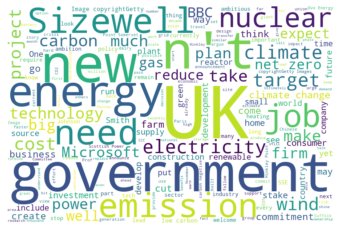

In [ ]:
i = 29

most_representative_texts = topic_model_reduced.get_representative_docs(i)
most_representative_texts = " ".join(most_representative_texts).replace("\r\n", " ")

tokens = nltk.word_tokenize(most_representative_texts)
lemmatized_text = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens if w not in string.punctuation])
stopworded_text = " ".join(w for w in nltk.word_tokenize(lemmatized_text) if w not in stop_words)

wordcloud = WordCloud(width=900, height=600,
                    background_color='white').generate(stopworded_text)

# filename = "/content/drive/MyDrive/colab_data/wordclouds/economist/topic_{}.png".format(i)
filename = "/content/drive/MyDrive/colab_data/wordclouds/bsh/{}.png".format((topic_model_reduced.get_topic_info(i)["Name"]).to_string().split(" ")[4])
    
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig(filename, dpi=400)

KeyError: ignored

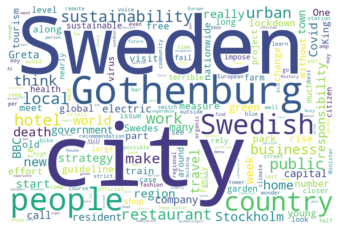

In [ ]:
for i in range(0, 90):
    most_representative_texts = topic_model_reduced.get_representative_docs(i)
    most_representative_texts = " ".join(most_representative_texts).replace("\r\n", " ")

    tokens = nltk.word_tokenize(most_representative_texts)
    lemmatized_text = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens if w not in string.punctuation])
    stopworded_text = " ".join(w for w in nltk.word_tokenize(lemmatized_text) if w not in stop_words)

    wordcloud = WordCloud(width=900, height=600,
                     background_color='white').generate(stopworded_text)

    # filename = "/content/drive/MyDrive/colab_data/wordclouds/economist/topic_{}.png".format(i)
    filename = "/content/drive/MyDrive/colab_data/wordclouds/bbc/{}.png".format(topic_model_reduced.get_topic_info()["Name"][i+1])
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(filename, dpi=400)

In [ ]:
from keras.models import load_model
import joblib
# Save model
topic_model_reduced.save("/content/drive/MyDrive/colab_data/economist/BERT_model")	
#joblib.dump()


#keras.models.save_model(topic_model_reduced, "/content/drive/MyDrive/colab_data/BERT_model.h5")

TypeError: ignored

In [ ]:
# my_model = BERTopic.load("my_model")	

In [ ]:
topic_model_reduced.find_topics("Germany")

([13, 6, 3, 18, 88],
 [0.7129680430940046,
  0.6618244602249747,
  0.654347215222872,
  0.6294444336721532,
  0.6229472689875823])

In [ ]:
topic_model_reduced.get_topic_info(13)

Topic  Count                                   Name
14     13    149  13_italy_bolsonaro_deaths_coronavirus

In [ ]:
topic_model_reduced.get_topic_info(6)

Topic  Count                                        Name
7      6    225  6_restrictions_england_government_scotland

In [ ]:
topic_model_reduced.get_topic_info(3)

Topic  Count                            Name
4      3    294  3_eu_brexit_agreement_european

In [ ]:
topic_model_reduced.get_topic_info(18)

Topic  Count                           Name
19     18    102  18_quarantine_travel_uk_spain

In [ ]:
topic_model_reduced.get_topic_info(88)

Topic  Count                               Name
89     88     11  88_sweden_denmark_swedens_swedish